In [1]:

import numpy as np
from matplotlib import pyplot as plt
import sys

import tensorflow as tf
from tensorflow import keras

from PIL import Image
import cv2 as cv

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

#For displaying images in colab
from google.colab.patches import cv2_imshow

# Image Processing

In [21]:
def getPrediction(image, model):
  return chr(np.argmax(model.predict(image, verbose=0))+65)

In [29]:
! rm /content/*.png

In [14]:
imgPath = '/content/img.jpg'

# Open and invert image
img = np.asarray(Image.open(imgPath))
img = cv.bitwise_not(img)

brightnessThreshold = 150
# Binarize 
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret,bin = cv.threshold(img,brightnessThreshold,255,cv.THRESH_BINARY)

#cv2_imshow(bin)

In [30]:
#Find contours in the image
contours = cv.findContours(bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

print("Found: " + str(len(contours)) + " contours")

minArea = 20
heightThreshold = 20
widthThreshold = 10
outPath = "/content/"
cnt = 0

for i, c in enumerate(contours): #For every contour
  #print("Area: ", cv.contourArea(c))
  if cv.contourArea(c) > minArea: #If big enoiugh to be a digit
    [X, Y, W, H] = cv.boundingRect(c) #Find hwight, width, and coordinated of bounding box around contour
    if(H > heightThreshold and W > widthThreshold): #If contour is tall enough and wide enough to be digit

      croppedImage = bin[Y:Y+H, X:X+W] #Crop digit from larger binarized image
      temp = cv.resize(croppedImage, dsize=(20, 20), interpolation=cv.INTER_CUBIC)

      #Add padding to convert to 28*28
      croppedImage = np.concatenate((np.zeros((len(temp), 4)), temp, np.zeros((len(temp), 4))), axis = 1)
      croppedImage = np.concatenate((np.zeros((4, len(croppedImage[0]))), croppedImage, np.zeros((4, len(croppedImage[0])))), axis = 0)
      croppedImage = np.reshape(np.asarray(croppedImage), (28,28,1))

      temp = croppedImage[None, :, :, :]

      c = getPrediction(temp, model)


      path = outPath + c + "X" + str(X) + "Y" + str(Y)  + ".png"
      cv.imwrite(path, croppedImage)
      cnt += 1
print("Found: " + str(cnt) + " letters")

Found: 198 contours
Found: 196 letters


# Machine Learning

## Data Prep

In [2]:
! pip install extra_keras_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from extra_keras_datasets import emnist
(train_images_0, train_labels_0), (test_images_0, test_labels_0) = emnist.load_data(type='balanced')

train_images_0 = train_images_0.astype("float32") / 255.0
test_images_0 = test_images_0.astype("float32") / 255.0

print(train_images_0.shape)

743900280/743900280 [==============================] - 63s 0us/step


(112800, 28, 28)


In [4]:
def printClass(id, num=10):
  cnt = 0
  for i, l in enumerate(test_labels_0):
    if(l == id):
      cnt += 1
      Image.fromarray(test_images_0[i]).show()
      if cnt >= num:
        break;


In [5]:
def numInRange(arr, low=10, high=35):
  cnt = 0
  for i, v in enumerate(arr):
    if v >= low and v <= high: cnt+=1
  return cnt

In [6]:
def classSubset(images, labels, low=10, high=35):
  num = numInRange(labels, low=low, high=high)
  new_images = np.zeros((num, 28, 28))
  new_labels = np.zeros((num, 1))
  cnt = 0
  for i in range(len(labels)):
    if labels[i] <= high and labels[i] >= low:
      new_images[cnt] = images[i]
      new_labels[cnt] = labels[i]
      cnt += 1
  return new_images, new_labels


In [7]:
train_images, train_labels = classSubset(train_images_0, train_labels_0)
test_images, test_labels = classSubset(test_images_0, test_labels_0)
train_images = np.reshape(train_images, (len(train_labels), 28, 28, 1))
test_images = np.reshape(test_images, (len(test_labels), 28, 28, 1))
train_labels -= 10
test_labels -= 10

In [143]:
print(np.max(train_labels))

25.0


In [8]:
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(62400, 28, 28, 1)
(62400, 1)
(10400, 28, 28, 1)
(10400, 1)


## Model Work

In [25]:
#setup model
model = keras.Sequential([
    #keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
    
    #First convolutional layer
    keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),

    #Second convolutional layer
    keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),

    #Third convolutional layer
    keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),

    keras.layers.Flatten(),

    #First fully connected layer
    keras.layers.Dense(200, use_bias=False),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),

    keras.layers.Dropout(0.5),

    #Second fully connected layer
    keras.layers.Dense(200, use_bias=False),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),

    keras.layers.Dropout(0.5),

    #Prediction layer
    keras.layers.Dense(26, activation = tf.nn.softmax)
])

## Training and Evaluation

In [28]:
#compile model
model.compile(optimizer=keras.optimizers.Adam(0.001),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

#train model, saving the history here will allow us to plot it later
historyCNN = model.fit(train_images, train_labels, epochs=14, validation_data=(test_images, test_labels), verbose=1)

#evaluate
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
print('Test accuracy:', test_acc)

Epoch 1/14
1950/1950 [==============================] - 15s 6ms/step - loss: 0.1471 - accuracy: 0.9488 - val_loss: 0.1509 - val_accuracy: 0.9561
Epoch 2/14
1950/1950 [==============================] - 11s 6ms/step - loss: 0.1434 - accuracy: 0.9506 - val_loss: 0.1408 - val_accuracy: 0.9563
Epoch 3/14
1950/1950 [==============================] - 11s 6ms/step - loss: 0.1351 - accuracy: 0.9517 - val_loss: 0.1486 - val_accuracy: 0.9535
Epoch 4/14
1950/1950 [==============================] - 11s 6ms/step - loss: 0.1312 - accuracy: 0.9542 - val_loss: 0.1502 - val_accuracy: 0.9548
Epoch 5/14
1950/1950 [==============================] - 11s 5ms/step - loss: 0.1255 - accuracy: 0.9554 - val_loss: 0.1459 - val_accuracy: 0.9570
Epoch 6/14
1950/1950 [==============================] - 11s 6ms/step - loss: 0.1255 - accuracy: 0.9553 - val_loss: 0.1448 - val_accuracy: 0.9560
Epoch 7/14
1950/1950 [==============================] - 11s 6ms/step - loss: 0.1201 - accuracy: 0.9565 - val_loss: 0.1472 - val_ac

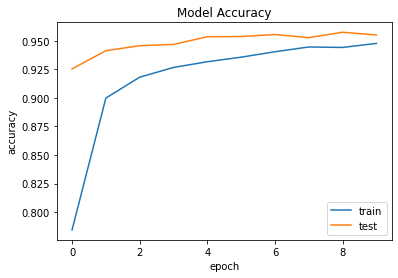

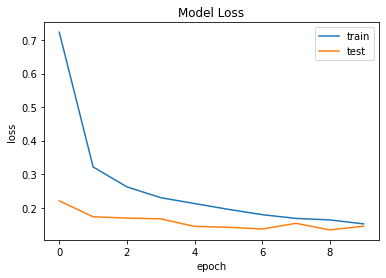

In [12]:
# Graph the accuracy of the model while it was training against the number of epochs
plt.plot(historyCNN.history['accuracy'])
plt.plot(historyCNN.history['val_accuracy'])

#Plot accuracies of SVM and random forest **Uncomment to plot other model's accuracies**
#plt.plot([n for n in range(10)], [svmAccuracy] * 10)
#plt.plot([n for n in range(10)], [rfAccuracy] * 10)

#plt.plot(rfAccuracy)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Graph the loss of the model while it was training against the number of epochs
plt.plot(historyCNN.history['loss'])
plt.plot(historyCNN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()